In [1]:
import os
import sys
import shutil
import csv
import random
import pickle
import numpy as np
import math
import json
from functools import partial
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

sys.path.append('../model')
from utils import amino_acid_to_number, tokenize, Tee
from functions import get_A2N_list, tokenize, make_train_val_test_lists_rand, prepare_data
from models import make_predictions, ProtDataset, Transformer_2k
from models import LinearModel, make_predictions_eval

In [2]:
results_path = "../results/GRB_VC/"
figure_path = "../figures/"

In [3]:
title_size = 36
type_size = 30

In [4]:
def logit(x):
    return np.log(x / (1 - x))

In [5]:
def g(phi):
    y_ = 1/(1 + np.exp(sign * -1 * phi))
    y = weight*y_ + bias
    return y

### GRB

In [6]:
device = torch.device('cuda:0')
data_name = "Faure2023_1_lenient"
in_path = "../Data/Data_prepared/" + data_name + ".csv"
datafile = pd.read_csv(in_path, index_col=None)
phenotypes, seqs, seqs1h = prepare_data(datafile)
n, L, AA_size = seqs1h.shape
d_max, k_max = L, 8

model_path = "/blue/juannanzhou/palash.sethi/Projects/ProteinLLEs/ProteinLLE_v4/output/Faure2023_1_lenient_Random_80.0%_rep_0/"

In [7]:
seqs_ex = seqs + AA_size*torch.tensor(range(L))
X = seqs_ex.to(device)
y = phenotypes.to(device)

seqs_df = pd.DataFrame([list(seq) for seq in datafile.mutated_sequence])
poss = np.where(np.array([len(seqs_df[i].value_counts()) for i in range(seqs_df.shape[1])]) == 2)[0] + 1

In [8]:
with open (model_path + 'test_list.pkl', 'rb') as file:
    test_list = pickle.load(file)

X_test, y_test = X[test_list], y[test_list]
test_dataset = ProtDataset(X_test, y_test)
test_loader = data.DataLoader(test_dataset,
                            batch_size=500,
                            shuffle=False,
                            drop_last=False)

In [9]:
phis = {}
preds = {}

#### 8th order model

In [26]:
model_name = "TF_3_BestModel"
model_best = torch.load(model_path + model_name)

In [27]:
model_best.eval()
pred, true = make_predictions(model_best, test_loader)
pearsonr(pred, true)[0]**2

0.8184523571062428

In [28]:
weight = dict(model_best.named_parameters())['sigmoid_scale.weight'].item()
bias = dict(model_best.named_parameters())['sigmoid_scale.bias'].item()

In [29]:
pred_ = (pred - bias)/weight
sign = round(pearsonr(y_test.flatten().cpu().detach().numpy(), pred_)[0])
pred_ = logit(pred_)

In [30]:
phis['8th-order'] = pred_
preds['8th-order'] = pred

Text(0.27, 0.85, '$R^2 = 0.82$')

/apps/pytorch/2.2.0/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


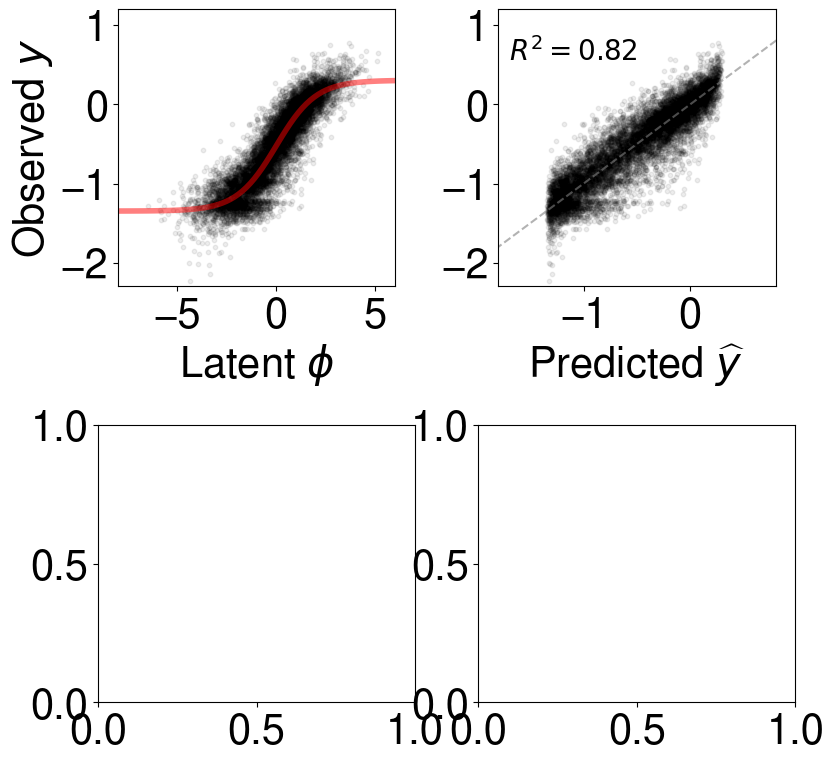

In [31]:
x = np.linspace(-10, 10, 100)

plt.rcParams['font.family'] =  'Nimbus Sans'
plt.rcParams['font.size'] = type_size
# plt.rcParams['mathtext.fontset'] ='cm'
alpha = .07

xmin, xmax = -1.8, .8
ymin, ymax = -2.3, 1.2


# fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1], 'wspace':.5, 'hspace':.4}, layout='tight', sharey=False)
fig, axs = plt.subplot_mosaic([['a', 'b'], ['c', 'd']],
                              gridspec_kw={'width_ratios': [1, 1], 'wspace':.2, 'hspace':.5}, sharey=False, layout='tight')

axs['a'].set_xticks(range(-20, 20, 5))
axs['a'].set_yticks(range(-20, 20, 1))
axs['b'].set_xticks(range(-20, 20, 1))
axs['b'].set_yticks(range(-20, 20, 1))

axs['a'].plot(x, g(x), color='red', linewidth=4, alpha=.5)
axs['a'].scatter(sign * pred_, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)

axs['a'].set_xlim(-8, 6)
axs['a'].set_ylim(ymin, ymax)
axs['a'].set_box_aspect(1)
axs['a'].get_figure().set_size_inches(9, 9)
axs['a'].set_xlabel('Latent $\phi$')
axs['a'].set_ylabel('Observed $y$')


r2 = np.round(pearsonr(pred, true)[0]**2, 2)
axs['b'].scatter(pred, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)
axs['b'].plot(x, x, color='gray', linestyle='--', label='y=x', alpha=.6)
axs['b'].set_box_aspect(1)
axs['b'].set_xlim(xmin, xmax)
axs['b'].set_ylim(ymin, ymax)
axs['b'].get_figure().set_size_inches(9, 9)
axs['b'].set_xlabel('Predicted $\widehat{y}$')
axs['b'].text(.27, .85, f'$R^2 = {r2}$', fontsize=20, ha='center', va='center', transform=axs['b'].transAxes)

#### Pairwise model

In [32]:
model_name = "TF_1_BestModel"
model_best = torch.load(model_path + model_name)

In [33]:
model_best.eval()
pred, true = make_predictions(model_best, test_loader)
pearsonr(pred, true)[0]**2

0.6588178707391033

In [34]:
weight = dict(model_best.named_parameters())['sigmoid_scale.weight'].item()
bias = dict(model_best.named_parameters())['sigmoid_scale.bias'].item()

In [35]:
pred_ = (pred - bias)/weight
sign = round(pearsonr(y_test.flatten().cpu().detach().numpy(), pred_)[0])
pred_ = logit(pred_)

In [36]:
phis['Pairwise'] = pred_
preds['Pairwise'] = pred

In [37]:
def g(phi):
    y_ = 1/(1 + np.exp(sign * -1 * phi))
    y = weight*y_ + bias
    return y

In [38]:
x = np.linspace(-10, 10, 100)

axs['c'].set_xticks(range(-20, 20, 5))
axs['c'].set_yticks(range(-20, 20, 1))
axs['d'].set_xticks(range(-20, 20, 1))
axs['d'].set_yticks(range(-20, 20, 1))

axs['c'].plot(x, g(x), color='red', linewidth=4, alpha=.5)
axs['c'].scatter(sign * pred_, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)

axs['c'].set_xlim(-8, 6)
axs['c'].set_ylim(ymin, ymax)
axs['c'].set_box_aspect(1)
axs['c'].get_figure().set_size_inches(9, 9)
axs['c'].set_xlabel('Latent $\phi$')
axs['c'].set_ylabel('Observed $y$')


r2 = np.round(pearsonr(pred, true)[0]**2, 2)
axs['d'].scatter(pred, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)
axs['d'].plot(x, x, color='gray', linestyle='--', label='y=x', alpha=.6)
axs['d'].set_box_aspect(1)
axs['d'].set_xlim(xmin, xmax)
axs['d'].set_ylim(ymin, ymax)
axs['d'].get_figure().set_size_inches(9, 9)
axs['d'].set_xlabel('Predicted $\widehat{y}$')
axs['d'].text(.27, .85, f'$R^2 = {r2}$', fontsize=20, ha='center', va='center', transform=axs['d'].transAxes)

plt.show()

In [39]:
fig.text(0.5, 0.92, 'GRB-1', ha='center', va='center', fontsize=title_size)
axs['a'].text(-.9, .5, '8th-order', ha='center', va='center', 
              transform=axs['a'].transAxes, color='black', fontsize=title_size)
axs['c'].text(-.9, .5, 'Pairwise', ha='center', va='center', 
              transform=axs['c'].transAxes, color='black', fontsize=title_size)

Text(-0.9, 0.5, 'Pairwise')

In [40]:
fig.savefig(figure_path + 'GE_fit_GRB.pdf', dpi=300, transparent=True, bbox_inches='tight')

/scratch/local/44687595/ipykernel_507081/3978994954.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(figure_path + 'GE_fit_GRB.pdf', dpi=300, transparent=True, bbox_inches='tight')


#### Compare MSE fits quantiles

In [41]:
mses_list = {}
nq = 40
qs = [np.quantile(true, q) for q in 1/nq*np.arange(0, nq)]

In [42]:
pred = preds['Pairwise']

In [43]:
mses = []
for i in range(nq - 1):
    pos = (true > qs[i]) * (true < qs[i + 1])
    mses.append(np.mean((true[pos] - pred[pos])**2))

In [44]:
mses_list['Pairwise'] = np.array(mses)

In [45]:
pred = preds['8th-order']

In [46]:
mses = []
for i in range(nq - 1):
    pos = (true > qs[i]) * (true < qs[i + 1])
    mses.append(np.mean((true[pos] - pred[pos])**2))

In [47]:
mses_list['8th-order'] = np.array(mses)

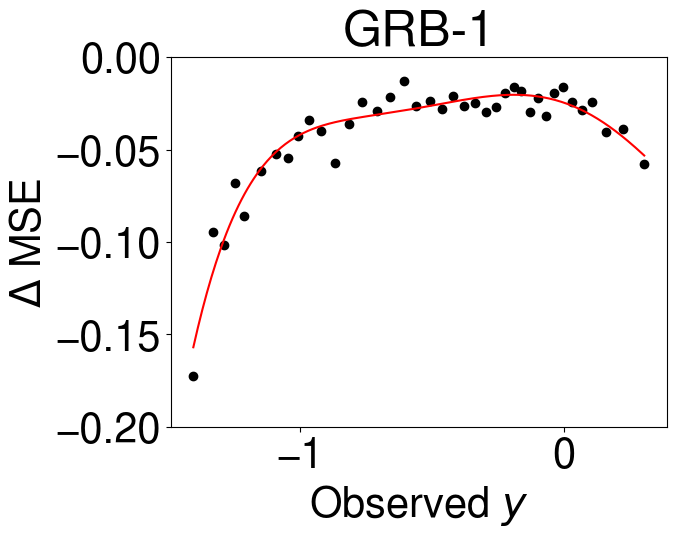

In [48]:
x, y = np.array(qs[1:]),  np.array(mses_list['8th-order'] - mses_list['Pairwise'])

plt.scatter(x, y, color = 'black')
plt.ylim(-.2, 0)

degree = 5
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)

x_new = np.linspace(x.min(), x.max(), 300)  # Generate more points for smoothness
plt.plot(x_new, polynomial(x_new), color='red', label=f'{degree}-degree polynomial fit')


plt.ylabel("$\Delta$ MSE")
plt.xlabel("Observed $y$")
plt.title("GRB-1")
plt.savefig(figure_path + 'GE_Delta_MSE_GRB.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### AAV2

In [49]:
device = torch.device('cuda:0')
data_name = "Sinai2021"
in_path = "../Data/Data_prepared/" + data_name + ".csv"
datafile = pd.read_csv(in_path, index_col=None)
phenotypes, seqs, seqs1h = prepare_data(datafile)
n, L, AA_size = seqs1h.shape
d_max, k_max = L, 8

model_path = "/blue/juannanzhou/palash.sethi/Projects/ProteinLLEs/ProteinLLE_v4/output/Sinai2021_Random_80.0%_rep_0/"

In [50]:
seqs_ex = seqs + AA_size*torch.tensor(range(L))
X = seqs_ex.to(device)
y = phenotypes.to(device)

In [51]:
seqs_df = pd.DataFrame([list(seq) for seq in datafile.mutated_sequence])

poss = np.where(np.array([len(seqs_df[i].value_counts()) for i in range(seqs_df.shape[1])]) == 2)[0] + 1

In [52]:
with open (model_path + 'test_list.pkl', 'rb') as file:
    test_list = pickle.load(file)

X_test, y_test = X[test_list], y[test_list]
test_dataset = ProtDataset(X_test, y_test)
test_loader = data.DataLoader(test_dataset,
                            batch_size=500,
                            shuffle=False,
                            drop_last=False)

In [53]:
phis = {}
preds = {}

#### 8th order model

In [54]:
model_name = "TF_3_BestModel"
model_best = torch.load(model_path + model_name)

In [55]:
model_best.eval()
pred, true = make_predictions(model_best, test_loader)
pearsonr(pred, true)[0]**2

0.8682986088175767

In [56]:
weight = dict(model_best.named_parameters())['sigmoid_scale.weight'].item()
bias = dict(model_best.named_parameters())['sigmoid_scale.bias'].item()

In [57]:
pred_ = (pred - bias)/weight
sign = round(pearsonr(y_test.flatten().cpu().detach().numpy(), pred_)[0])
pred_ = logit(pred_)

In [58]:
phis['8th-order'] = pred_
preds['8th-order'] = pred

/apps/pytorch/2.2.0/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


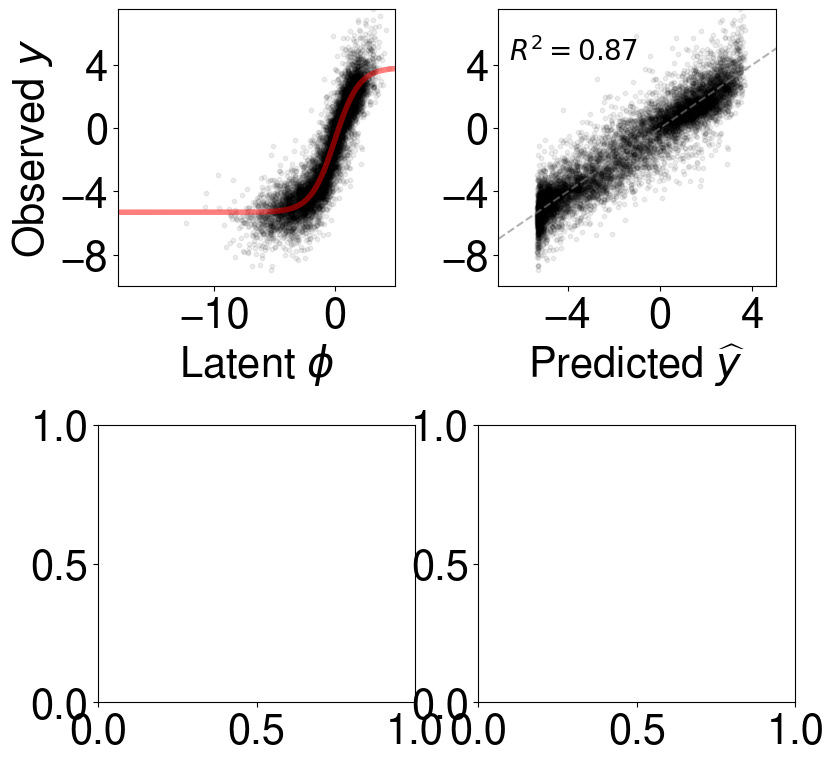

In [59]:
x = np.linspace(-20, 20, 1000)

plt.rcParams['font.family'] =  'Nimbus Sans'
plt.rcParams['font.size'] = type_size
# plt.rcParams['mathtext.fontset'] ='cm'

xmin, xmax = -7, 5
ymin, ymax = -10, 7.5
ticks = [-8, -4, 0, 4]
fig, axs = plt.subplot_mosaic([['a', 'b'], ['c', 'd']],
                              gridspec_kw={'width_ratios': [1, 1], 'wspace':.2, 'hspace':.5}, sharey=False, layout='tight')

axs['a'].set_xticks(range(-20, 20, 10))
axs['a'].set_yticks(ticks)
axs['b'].set_xticks(ticks)
axs['b'].set_yticks(ticks)

axs['a'].set_xlim(-18, 5)
axs['a'].set_ylim(ymin, ymax)
axs['b'].set_xlim(xmin, xmax)
axs['b'].set_ylim(ymin, ymax)

axs['a'].plot(x, g(x), color='red', linewidth=4, alpha=.5)
axs['a'].scatter(sign * pred_, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)

axs['a'].set_box_aspect(1)
axs['a'].get_figure().set_size_inches(9, 9)
axs['a'].set_xlabel('Latent $\phi$')
axs['a'].set_ylabel('Observed $y$')


r2 = np.round(pearsonr(pred, true)[0]**2, 2)
axs['b'].scatter(pred, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)
axs['b'].plot(x, x, color='gray', linestyle='--', label='y=x', alpha=.6)
axs['b'].set_box_aspect(1)
axs['b'].get_figure().set_size_inches(9, 9)
axs['b'].set_xlabel('Predicted $\widehat{y}$')
axs['b'].text(.27, .85, f'$R^2 = {r2}$', fontsize=20, ha='center', va='center', transform=axs['b'].transAxes)

plt.show()

#### Pairwise order model

In [60]:
model_name = "TF_1_BestModel"
model_best = torch.load(model_path + model_name)

In [61]:
model_best.eval()
pred, true = make_predictions(model_best, test_loader)
pearsonr(pred, true)[0]**2

0.8334281504070069

In [62]:
weight = dict(model_best.named_parameters())['sigmoid_scale.weight'].item()
bias = dict(model_best.named_parameters())['sigmoid_scale.bias'].item()

In [63]:
pred_ = (pred - bias)/weight
sign = round(pearsonr(y_test.flatten().cpu().detach().numpy(), pred_)[0])
pred_ = logit(pred_)

/scratch/local/44687595/ipykernel_507081/3775619766.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x / (1 - x))


In [64]:
phis['Pairwise'] = pred_
preds['Pairwise'] = pred

In [65]:
axs['c'].set_xticks(range(-20, 20, 10))
axs['c'].set_yticks(ticks)
axs['d'].set_xticks(ticks)
axs['d'].set_yticks(ticks)

axs['c'].set_xlim(-18, 5)
axs['c'].set_ylim(ymin, ymax)
axs['d'].set_xlim(xmin, xmax)
axs['d'].set_ylim(ymin, ymax)

axs['c'].plot(x, g(x), color='red', linewidth=4, alpha=.5)
axs['c'].scatter(sign * pred_, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)

axs['c'].set_box_aspect(1)
axs['c'].get_figure().set_size_inches(9, 9)
axs['c'].set_xlabel('Latent $\phi$')
axs['c'].set_ylabel('Observed $y$')


r2 = np.round(pearsonr(pred, true)[0]**2, 2)
axs['d'].scatter(pred, true, alpha=alpha, color='black', marker='o', s=10, rasterized=True)
axs['d'].plot(x, x, color='gray', linestyle='--', label='y=x', alpha=.6)
axs['d'].set_box_aspect(1)
axs['d'].get_figure().set_size_inches(9, 9)
axs['d'].set_xlabel('Predicted $\widehat{y}$')
axs['d'].text(.27, .85, f'$R^2 = {r2}$', fontsize=20, ha='center', va='center', transform=axs['d'].transAxes)

plt.show()

In [66]:
fig.text(0.5, 0.92, 'AAV2 Capsid', ha='center', va='center', fontsize=title_size)
fig.savefig(figure_path + 'GE_fit_AAV.pdf', dpi=300, transparent=True, bbox_inches='tight')

/scratch/local/44687595/ipykernel_507081/3470189179.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(figure_path + 'GE_fit_AAV.pdf', dpi=300, transparent=True, bbox_inches='tight')


#### Compare MSE fits quantiles

In [67]:
mses_list = {}
nq = 40
qs = [np.quantile(true, q) for q in 1/nq*np.arange(0, nq)]

In [68]:
pred = preds['Pairwise']

In [69]:
mses = []
for i in range(nq - 1):
    pos = (true > qs[i]) * (true < qs[i + 1])
    mses.append(np.mean((true[pos] - pred[pos])**2))

In [70]:
mses_list['Pairwise'] = np.array(mses)

In [71]:
pred = preds['8th-order']

In [72]:
mses = []
for i in range(nq - 1):
    pos = (true > qs[i]) * (true < qs[i + 1])
    mses.append(np.mean((true[pos] - pred[pos])**2))

In [73]:
mses_list['8th-order'] = np.array(mses)

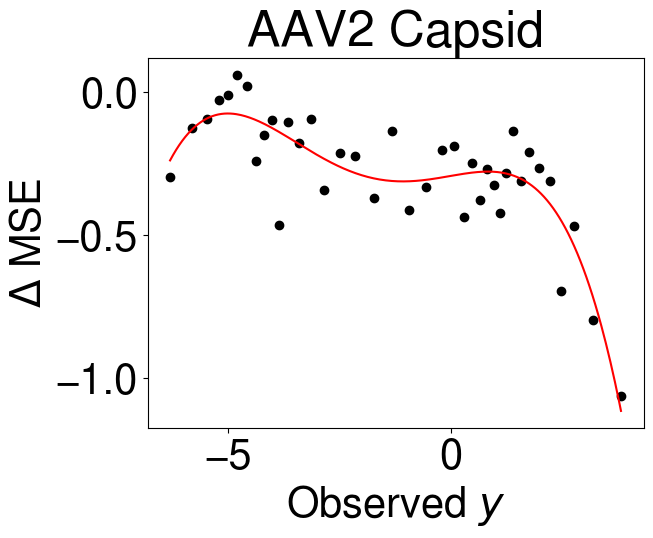

In [74]:
x, y = np.array(qs[1:]),  np.array(mses_list['8th-order'] - mses_list['Pairwise'])

plt.scatter(x, y, color = 'black')

degree = 4
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)

x_new = np.linspace(x.min(), x.max(), 300)  # Generate more points for smoothness
plt.plot(x_new, polynomial(x_new), color='red', label=f'{degree}-degree polynomial fit')


plt.ylabel("$\Delta$ MSE")
plt.xlabel("Observed $y$")
plt.title("AAV2 Capsid")
plt.savefig(figure_path + 'GE_Delta_MSE_AAV2.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()